In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm, skew
from sklearn import preprocessing
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
df = pd.read_csv('train.tsv', sep = '\t')

In [3]:
df.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.000,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.000,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.000,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.000,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.000,0,Complete with certificate of authenticity


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1482535 entries, 0 to 1482534
Data columns (total 8 columns):
train_id             1482535 non-null int64
name                 1482535 non-null object
item_condition_id    1482535 non-null int64
category_name        1476208 non-null object
brand_name           849853 non-null object
price                1482535 non-null float64
shipping             1482535 non-null int64
item_description     1482531 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 90.5+ MB


In [5]:
df.price.describe()

count   1482535.000
mean         26.738
std          38.586
min           0.000
25%          10.000
50%          17.000
75%          29.000
max        2009.000
Name: price, dtype: float64


 mu = 26.75 and sigma = 38.59



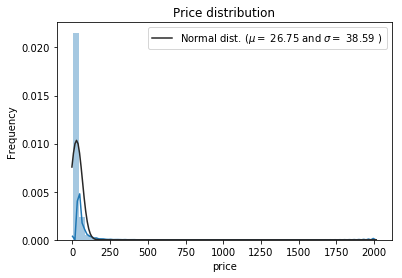

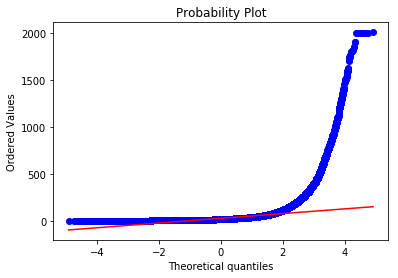

In [6]:
df = df.loc[df['price'] > 0]

sns.distplot(df['price'], fit = norm);
(mu, sigma) = norm.fit(df['price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Price distribution')

fig = plt.figure()
res = stats.probplot(df['price'], plot=plt)
plt.show();


 mu = 2.98 and sigma = 0.75



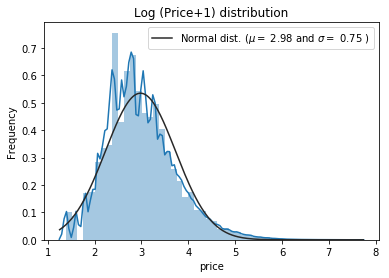

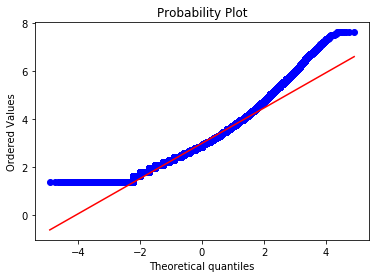

In [7]:
sns.distplot(np.log1p(df['price']), fit = norm);
(mu, sigma) = norm.fit(np.log1p(df['price']))
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('Log (Price+1) distribution')

fig = plt.figure()
res = stats.probplot(np.log1p(df['price']), plot=plt)
plt.show();

In [8]:
df["price"] = np.log1p(df["price"])

In [9]:
df.isnull().sum()

train_id                  0
name                      0
item_condition_id         0
category_name          6314
brand_name           632336
price                     0
shipping                  0
item_description          4
dtype: int64

We will replace all NaN values in these 3 columns with "missing". There are 82,427 descriptions are "No description yet". So we will replace them by "missing" too.

In [11]:
NUM_BRANDS = 2500
NAME_MIN_DF = 10
MAX_FEAT_DESCP = 50000

df["category_name"] = df["category_name"].fillna("Other").astype("category")
df["brand_name"] = df["brand_name"].fillna("unknown")

pop_brands = df["brand_name"].value_counts().index[:NUM_BRANDS]
df.loc[~df["brand_name"].isin(pop_brands), "brand_name"] = "Other"

df["item_description"] = df["item_description"].fillna("None")
df["item_condition_id"] = df["item_condition_id"].astype("category")
df["brand_name"] = df["brand_name"].astype("category")

In [14]:
df.dtypes

train_id                int64
name                   object
item_condition_id    category
category_name        category
brand_name           category
price                 float64
shipping                int64
item_description       object
dtype: object

In [15]:
target = df.price.values
features = df[['name', 'item_condition_id', 'category_name', 'brand_name', 'shipping', 'item_description']].copy()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2, random_state=0)

In [19]:
features.dtypes

name                   object
item_condition_id    category
category_name        category
brand_name           category
shipping                int64
item_description       object
dtype: object

In [20]:
preprocess = ColumnTransformer(
    [('item_condition_category', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['item_condition_id']),
     ('brand_name_category', OneHotEncoder(dtype='int', handle_unknown='ignore'), ['brand_name']),
     ('category_name_countvec', CountVectorizer(), 'category_name'),
     ('name_countvec', CountVectorizer(min_df=NAME_MIN_DF), 'name'),
     ('description_tfidf', TfidfVectorizer(max_features = MAX_FEAT_DESCP, stop_words = 'english', ngram_range=(1,3)), 'item_description')],
    remainder='passthrough')

In [21]:
model = make_pipeline(
    preprocess,
    Ridge(solver = "lsqr", fit_intercept=False))

In [22]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('columntransformer', ColumnTransformer(n_jobs=None, remainder='passthrough', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('item_condition_category', OneHotEncoder(categorical_features=None, categories=None, dtype='int',
       handle_unknown='ignore', n_va...t_intercept=False, max_iter=None,
   normalize=False, random_state=None, solver='lsqr', tol=0.001))])

In [23]:
y_train_pred = model.predict(X_train)
y_pred = model.predict(X_test)

train_rmse = np.sqrt(mean_squared_error(y_train_pred, y_train))
test_rmse = np.sqrt(mean_squared_error(y_pred, y_test))
print('Train RMSE: %.4f' % train_rmse)
print('Test RMSE: %.4f' % test_rmse)

Train RMSE: 0.4534
Test RMSE: 0.4674
